# Ellipsometry

Scott Prahl

April 2018

In [1]:
# Execute these lines first
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pypolar.fresnel as fresnel

# Basic Ellipsometry

## Ellipsometer Layout

The basic ellipsometer configuration is shown below.  Typically the incident light is linearly polarized but the reflected light is, in general, elliptically polarized. 

<img src="http://omlc.org/~prahl/host/453/week5/ellipsometry.png" width="100%">

The parameter $\Delta$ describes the change in phase from parallel polarization after reflection.  The amplitude ratio (parallel vs perpendicular reflected light) is represented by $\tan\psi$.  

## Fresnel Reflection

For dielectrics like glass, the amount of reflected light is determined by a single number, the index of refraction $n$.  However, in semi-conductors and metals the index of refraction is a complex number $m = n - j \kappa$.  

The Fresnel formulas for light incident from a vacuum onto a flat surface at an angle $\theta$ from the normal with refractive index $m$ varies with the orientation of the electric field.  The plane of incidence is defined as containing both the incident direction and the normal to the surface.  If the incident field is parallel to the plane of incidence then
$$
r_p=r_\parallel ={m^2\cos\theta-\sqrt{m^2-\sin^2\theta}\over
                        m^2\cos\theta+\sqrt{m^2-\sin^2\theta}}
$$
If the incident field is perpendicular to the plane of incidence then
$$
r_s=r_\perp ={\cos\theta-\sqrt{m^2-\sin^2\theta}\over
                    \cos\theta+\sqrt{m^2-\sin^2\theta}}
$$

## Fundamental Equation of Ellipsometry

Ellipsometers are used to determine the parameters $\psi$ and $\Delta$ which can be used to calculate $\rho$
$$
\rho = {r_p(\theta_i)\over r_s(\theta_i)} = \tan\psi \cdot e^{j \Delta}
$$

The graph below shows how $\psi$ and $\Delta$ vary with the incidence angle

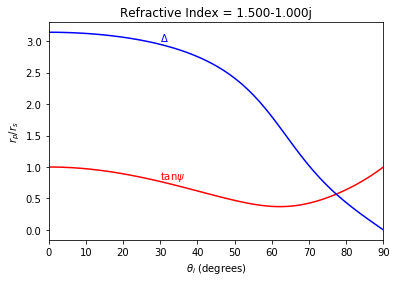

In [2]:
angles = np.linspace(0.001,90,91)
rads = np.radians(angles)
m=1.5-1.0j

ratio = fresnel.r_par(m,rads)/fresnel.r_per(m,rads)

plt.plot(angles, np.abs(ratio), color='red')
plt.plot(angles, np.angle(ratio),color='blue')

plt.xlabel(r"$\theta_i$ (degrees)")
plt.ylabel(r'$r_p/r_s$')
plt.title('Refractive Index = {:.3f}'.format(m))

plt.xlim(0,90)
plt.annotate(r'$\Delta$', xy=(30,3), color='blue')
plt.annotate(r'$\tan\psi$', xy=(30,0.8), color='red')

plt.show()

## Determining the complex index of refraction

A convenient formula for an isotropic, uniform sample is given in 
[Measurement of the Thickness and Refractive Index of Very Thin Films and the Optical Properties of Surfaces by Ellipsometry](https://archive.org/details/jresv67An4p363) so that when $\rho$ and $\theta$ are known, the complex index of refraction can be calculated.
$$
m = \tan\theta \sqrt{1-{4\rho\sin^2\theta\over (1+\rho)^2}}
$$

To test this, let's first calculate $\rho$ for a known complex index of refraction.  Next, we will see if we can recover this known index of refraction using only $(\rho,\theta)$.

We will test with incidence angles from 1° to 89°.  We avoid 0° and 90° because these angles are either impossible or do not contain sufficient information to invert.

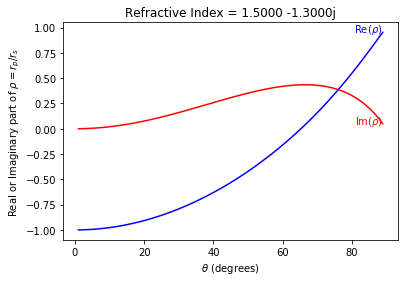

In [3]:
m = 1.5-1.3j
th = np.linspace(1,89,90)
theta = np.radians(th)
rho = fresnel.ellipsometry_rho(m, theta)

plt.plot(th, rho.real, color='blue')
plt.plot(th, rho.imag, color='red')

plt.annotate(r'Re($\rho$)', xy=(th[-1],rho[-1].real), color='blue', ha='right')
plt.annotate(r'Im($\rho$)', xy=(th[-1],rho[-1].imag), color='red', ha='right')

plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel(r'Real or Imaginary part of $\rho=r_p/r_s$')
plt.title('Refractive Index = %.4f %.4fj'%(m.real,m.imag))

plt.show()

Now validate that the known index of refraction is recovered and that the equation above is valid.

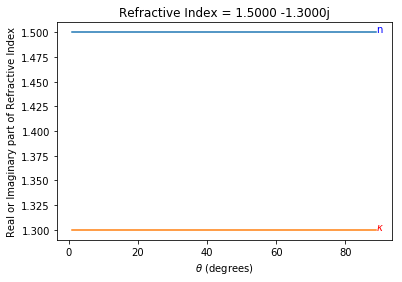

In [4]:
# Now calculate the 
m2 = fresnel.ellipsometry_index(rho, theta)

plt.plot(th, m2.real)
plt.plot(th, -m2.imag)

plt.annotate(r'n', xy=(th[-1],m2[-1].real), color='blue')
plt.annotate(r'$\kappa$', xy=(th[-1],-m2[-1].imag), color='red')

plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel('Real or Imaginary part of Refractive Index')
plt.title('Refractive Index = %.4f %.4fj'%(m.real,m.imag))

plt.show()

Quantitatively show that things work out

In [5]:
th = 70
theta = th*np.pi/180
m = 1.5 - 2.0j
print('At and incidence angle of %.1f'%th)
print('Refractive   Index = {:.3f}'.format(m))

rho = fresnel.ellipsometry_rho(m,theta)
m2 = fresnel.ellipsometry_index(rho,theta)         
print('Ellipsometry Index = {:.3f} using rho'.format(m2))

At and incidence angle of 70.0
Refractive   Index = 1.500-2.000j
Ellipsometry Index = 1.500-2.000j using rho


# Rotating Ellipsometer

An ellipsometer is usually used at a single angle of incidence with linear or circularly polarized light.  The reflected light passes through a rotating analyzer before hitting the detector. The reflected light is monitored over 360° with each rotation.  This produces a sinusoidal signal that looks like
$$
I(\phi) = I_\mathrm{DC} + I_C \cos 2\phi + I_S \sin 2\phi
$$
where $\phi$ is the angle that the analyzer makes with the plane of incidence.

Our ellipsometer digitizes the signal every 5 degrees to produce an array of 72 elements, $I_i$.  The first challenge is to determine the coefficients $I_\mathrm{DC}$, $I_S$, and $I_C$ that characterize the signal
$$
I_i = I_\mathrm{DC}  + I_C \cos2\phi_i + I_S \sin2\phi_i
$$
where, $\phi_i=2\pi i/N$

## Fitting to a sinusoid

So the ellipsometry problem becomes one fitting the detected signal $I(\phi)$ to find average value $I_\mathrm{DC}$ as well as the two Fourier coefficients $I_S$ and $I_C$ 
$$
I(\phi) = I_\mathrm{DC} + I_C \cos 2\phi + I_S \sin 2\phi
$$

The DC offset $I_\mathrm{DC}$ is found by averaging over one analyzer rotation ($0\le\phi\le2\pi$)
$$
I_\mathrm{DC} = {1\over N}\sum_{i=0}^{N-1} I_i
$$

The Fourier coefficients are given by
$$ 
 I_S = {1\over \pi} \int_0^{2\pi} I(\phi)\sin(2\phi) \,{\rm d} \phi 
\qquad\mbox{and}\qquad
 I_C = {1\over \pi} \int_0^{2\pi} I(\phi)\cos(2\phi) \,{\rm d} \phi
$$

For the discrete case this becomes
$$ 
 I_S = {1\over \pi} \sum_{i=0}^{N-1} I_i\sin2\phi_i  \cdot \Delta\phi
\qquad\mbox{and}\qquad
 I_C = {1\over \pi} \sum_{i=0}^{N-1} I_i\cos2\phi_i \cdot \Delta\phi
$$
where $\Delta\phi=2\pi/N$.  

If we substitute for for $\Delta\phi$, then we recognize that $I_C$ and $I_S$ are just the weighted averages of $I_i$ over one drum rotation
$$
 I_S = {1\over N} \sum_{i=0}^{N-1} I_i\cdot 2\sin 2\phi_i
\qquad\mbox{and}\qquad
 I_C = {1\over N} \sum_{i=0}^{N-1} I_i\cdot 2\cos 2\phi_i
$$
where the quantities in brackets need only be calculated once at the beginning of the analysis.  Every rotation of the drum requires three averages to be calculated.

Below is a test with random noise added to a known sinsoidal signal.

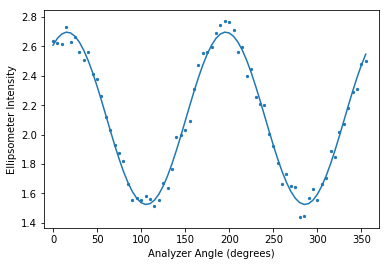

I_DC expected=2.100000 obtained=2.110738
I_S  expected=0.300000 obtained=0.310294
I_C  expected=0.500000 obtained=0.498200


In [6]:
def fake_signal(phi,IDC,IS,IC,error):
    return IDC+IS*np.sin(2*phi)+IC*np.cos(2*phi)+(1-2*np.random.random(len(phi)))*error

degrees = np.linspace(0,360,num=72,endpoint=False)
phi = degrees*np.pi/180

# this is the signal we will try to recover
a=2.1
b=0.3
c=0.5
error=0.1
signal=fake_signal(phi,a,b,c,error)

# finding the offset and coefficients of the sin() and cos() terms
# np.average sums the array and divides by the number of elements N
I_DC = np.average(signal)
I_S = 2*np.average(signal*np.sin(2*phi))
I_C = 2*np.average(signal*np.cos(2*phi))

plt.scatter(degrees,signal,s=5)
plt.plot(degrees,I_DC + I_S*np.sin(2*phi) + I_C*np.cos(2*phi))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

print("I_DC expected=%f obtained=%f" % (a,I_DC))
print("I_S  expected=%f obtained=%f" % (b,I_S))
print("I_C  expected=%f obtained=%f" % (c,I_C))

## Ellipsometry Parameters

If linearly polarized light is incident with an azimuthal angle $P$ 
(where $P=0^\circ$ is in the plane of incidence) then
the normalized intensity is 
$$
{I(\phi)\over I_\mathrm{DC}} = 1 + \alpha \cos 2\phi + \beta\sin 2\phi
$$
where
$$
\alpha = {I_C\over I_\mathrm{DC}} = {\tan^2\psi -\tan^2 P \over \tan^2\psi+\tan^2 P}
\qquad
\mbox{and}
\qquad
\beta = {I_S\over I_\mathrm{DC}} = {2\tan\psi \cos\Delta \tan P \over \tan^2\psi+\tan^2 P}
$$

The parameters $\psi$ and $\Delta$ can be calculated from $\alpha$ and $\beta$
$$
\tan\psi = \sqrt{1+\alpha\over 1-\alpha}\cdot |\tan P| 
\qquad
\mbox{and}
\qquad
\cos\Delta = {\beta\over\sqrt{1-\alpha^2}}\cdot{\tan P\over |\tan P|} 
$$

Or in terms of $I_\mathrm{DC}$, $I_S$, and $I_C$
$$
\tan\psi = \sqrt{I_\mathrm{DC}+I_C\over I_\mathrm{DC}-I_C}\cdot |\tan P|
\qquad
\mbox{and}
\qquad
\cos\Delta = {I_S\over\sqrt{I_\mathrm{DC}^2-I_C^2}}\cdot{\tan P\over |\tan P|}
$$

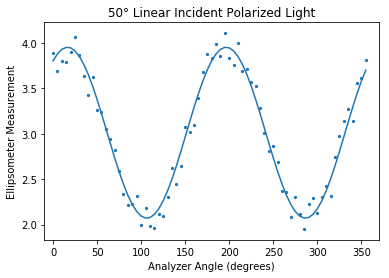

In [7]:
# produce normalized signal for Delta and tanpsi
def ellipsometer_signal(phi,Delta,tanpsi,P):
    sig = (tanpsi**2-np.tan(P)**2) * np.cos(2*phi)
    sig += 2*tanpsi*np.cos(Delta)*np.tan(P)*np.sin(2*phi)
    sig /= tanpsi**2+np.tan(P)**2
    return 1+sig

P=50
signal = fake_signal(phi, 3, 0.5, 0.8, 0.2)
scale_factor = signal.mean()
Delta,tanpsi = fresnel.ellipsometry_parameters(phi, signal, P*np.pi/180)
fitted_signal = scale_factor*ellipsometer_signal(phi,Delta,tanpsi,P*np.pi/180)

plt.scatter(degrees,signal,s=5)
plt.plot(degrees,fitted_signal)

plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Measurement")
plt.title("%d° Linear Incident Polarized Light" % P)
plt.xlim(-10,370)
plt.show()

## Expected Signal Based on Fresnel Reflection

The expression for the electric field at the detector can be found using Jones matrices.  The incident light passes through a linear polarizer at an angle $P$ relative to the plane of incidence.  The light is reflected off the surface and then passes through a linear analyzer at an angle $\phi$.  The electric field is
$$
E_D=
\left[\begin{array}{cc}
\cos^2\phi & \sin \phi\cos\phi\\
\sin\phi\cos\phi & \sin^2\phi\\
\end{array}\right]
\cdot
\left[\begin{array}{cc}
r_p(\theta_i) & 0\\
0 & r_s(\theta_i)\\
\end{array}\right]
\cdot
\left[\begin{array}{cc}
\cos^2P & \sin P\cos P\\
\sin P\cos P & \sin^2 P\\
\end{array}\right]
\cdot
\left[\begin{array}{c}
1\\
0\\
\end{array}\right]
$$
Therefore
$$
E_D=\left[\begin{array}{cc}
r_p(\theta_i)\cos^2P\cos^2\phi+r_s(\theta_i)\cos P\cos\phi\sin P \sin\phi\\
r_p(\theta_i)\cos^2 P\cos\phi\sin\phi+r_s(\theta_i)\cos P\sin P \sin^2\phi\\
\end{array}\right]
$$
and since the intensity is product of $E_D$ with its conjugate transpose $I=E_D\cdot E_D^T$ with a bit 
$$
I_D = \cos^2P \cdot\left|r_p(\theta_i)\cos P \cos\phi+r_(\theta_i)\sin P \sin\phi\right|^2
$$

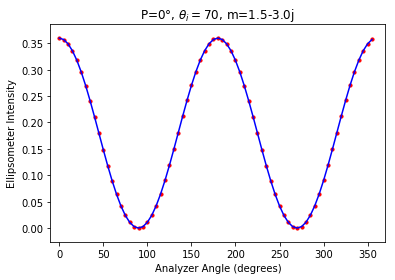

Fitted Delta=107.7°, tanpsi=0.652
Recovered refractive index = 1.500 -3.000j


In [8]:
def theory_signal(phi, m, thetai, P):
    """
    returns expected relative signal for an ellipsometer  
    
    Args:
        m      complex index of refraction of sample
        thetai angle of incidence (from normal)
        P      angle of linearly incident polarized light
        phi    angle of the analyzer     
    """
    sig  = fresnel.r_par(m,thetai)*np.cos(P)*np.cos(phi)
    sig += fresnel.r_per(m,thetai)*np.sin(P)*np.sin(phi)
    return np.cos(P)**2*abs(sig)**2

# Experimental Conditions
m=1.5-3j                # sample index of refraction
P=0.1                   # incident polarization azimuth (degrees)
th=70                   # angle of incidence (degrees)
theta = np.radians(th)  # angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
# On reflected intensity for each angle of the rotating analyzer
phi = np.linspace(0,360,num=72,endpoint=False)*np.pi/180
t_sig = theory_signal(phi, m, theta, P*np.pi/180)

# Calculate Delta, tanpsi, and index from 72 intensities
Delta,tanpsi = fresnel.ellipsometry_parameters(phi, t_sig, P*np.pi/180)
rho = tanpsi * np.exp(-1j*Delta)
m2 = fresnel.ellipsometry_index(rho, theta)
fitted_signal = t_sig.mean()*ellipsometer_signal(phi,Delta,tanpsi,P*np.pi/180)

# Show the results
plt.scatter(phi*180/np.pi,t_sig,color="red", s=10)
plt.plot(phi*180/np.pi,fitted_signal,color="blue")
plt.title(r"P=%d°, $\theta_i=$%d, m=%.1f-%.1fj" % (P,th,m.real,-m.imag))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

print("Fitted Delta=%.1f°, tanpsi=%.3f" % (Delta*180/np.pi,tanpsi))
print("Recovered refractive index = %.3f %.3fj" % (m2.real,-m2.imag))

## Now the question is how sensitive to noise is this result?

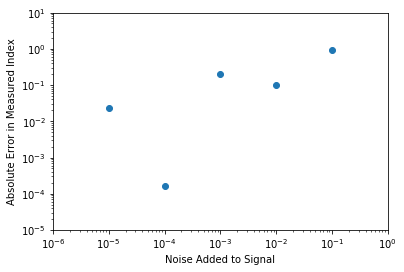

In [9]:
# same as above plus noise
def theory_signal_noisy(phi, m, thetai, P, error):
    signal = theory_signal(phi, m, thetai, P)
    noise  = (1-2*np.random.random(len(phi)))*error
    return signal + noise

# Experimental Conditions
m=1.5-0j                # sample index of refraction
P=45                    # incident polarization azimuth (degrees)
th=30                   # angle of incidence (degrees)
theta = np.radians(th)  # angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
phi = np.linspace(0,360,num=72,endpoint=False)*np.pi/180

dev = np.zeros(5)
err = np.zeros(5)
for i in range(5):
    error = 0.1*10**(-i)
    t_sig = theory_signal_noisy(phi, m, theta, P*np.pi/180, error)
    Delta,tanpsi = fresnel.ellipsometry_parameters(phi, t_sig, P*np.pi/180)
    rho = tanpsi * np.exp(1j*Delta)
    m2 = fresnel.ellipsometry_index(rho, theta)
    dev[i]=abs(m2-m)
    err[i]=error

plt.scatter(err,dev)
plt.xlim(0.000001,1)
plt.ylim(0.00001,10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise Added to Signal')
plt.ylabel('Absolute Error in Measured Index')
plt.show()